# Attribution Modelling

* Attribution Modeling is a set of rules for assigning credit to the various touch points in the conversion path.

* This method helps us understand how the prospect customer travels through the path to purchase.

* There are many attribution models available, a specific model should be chosen based on the products sold and the length of buying cycle.

* We use the Criteo Attribution modeling dataset to build attribution models which optimize the budget allocation for various marketing campaigns

# Dataset Description
This dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user. For each banner we have detailed information about the context, if it was clicked, if it led to a conversion and if it led to a conversion that was attributed to Criteo or not.

* timestamp: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.
* uid: a unique user identifier
* campaign: a unique identifier for the campaign
* conversion: 1 if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)
* conversion_timestamp: the timestamp of the conversion or -1 if no conversion was observed
* conversion_id: a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion
* attribution: 1 if the conversion was attributed to Criteo, 0 otherwise
* click: 1 if the impression was clicked, 0 otherwise
* click_pos: the position of the click before a conversion (0 for first-click)
* click_nb: number of clicks. More than 1 if there was several clicks before a conversion
* cost: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)
* cpo: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)
* time_since_last_click: the time since the last click (in s) for the given impression
* cat(1-9): contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).

In [ ]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import keras

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [ ]:
#Reading the dataset using Pandas
DATA_FILE='criteo_attribution_dataset.tsv.gz'
df_Attribution = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

In [ ]:
df_Attribution['day'] = np.floor(df_Attribution.timestamp / 86400.).astype(int)

## Data Preparation

In [ ]:
# Helper functions for the initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [ ]:
# Taking a smaple of 400 campaigns for the attribution modelling
n_campaigns = 400

#Creating Journey ID column from Uid & Coversion Id and Normalising the Time Stamps
df_Attribution = add_derived_columns(df_Attribution)

#
df_Attribution = sample_campaigns(df_Attribution, n_campaigns)

#Filtering the journey length with minimum touchpoints
df_Attribution = filter_journeys_by_length(df_Attribution, 2)

#The data is imbalanced for conversions. Balance the data so that Data driven models can be trained
df_Attribution = balance_conversions(df_Attribution)

#Create one hot encoding for Cat1-9 columns and Campaign column
df_Attribution = map_one_hot(df_Attribution, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df_Attribution = map_one_hot(df_Attribution, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])


In [ ]:
#Shape of the data after preprocessing
df_Attribution.shape

(588892, 28)

## Journey Length

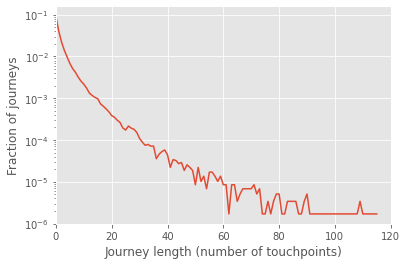

In [ ]:
def journey_length_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_length_histogram(df_Attribution)

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

## Journey Length of journeys that were converted and not converted

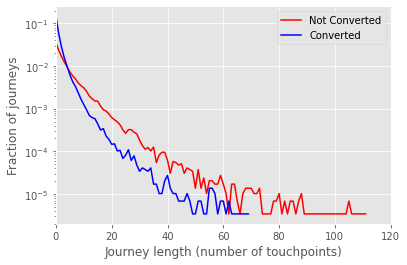

In [ ]:
def journey_length_hist(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_length_hist(df_Attribution[df_Attribution.conversion==0])
hist_x1, hist_y1 = journey_length_hist(df_Attribution[df_Attribution.conversion==1])
plt.plot(range(len(hist_x)), hist_y, label='Not Converted', color = 'red')
plt.plot(range(len(hist_x1)), hist_y1, label='Converted', color = 'blue')
plt.yscale('log')
plt.xlim(0, 120)
plt.legend()
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

# Attribution Modelling

### Single Touch Attribution Models
     1. First Touch Attribution
     2. Last Touch Attribution
### Multi-Touch Attribution Models
     1. Linear Attribution
     2. Time-Deccay Attribution
     3. U-Shape Attribution
### Data-Driven Attribution Models
     1. Logistic Regression
     2. LSTM (Long Short Term Memory)
     3. LSTM with Attention

# Single-Touch Attribution

## Last Touch Attribution

Last-touch attribution, is an easy-to-understand, single-touch model. With the lead qualified model, 100% of the credit for a sale is given to the last-touch milestone before a lead converts and becomes a customer. 

#### Pros of Last Touch Attribution:
* Easy to understand
* Easy to set up
* Great for short buying cycles/customer journeys

#### Cons of Last Touch Attribution:
* Overly simplistic
* Not useful for organizations with a long buying cycle

In [ ]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df_Attribution)

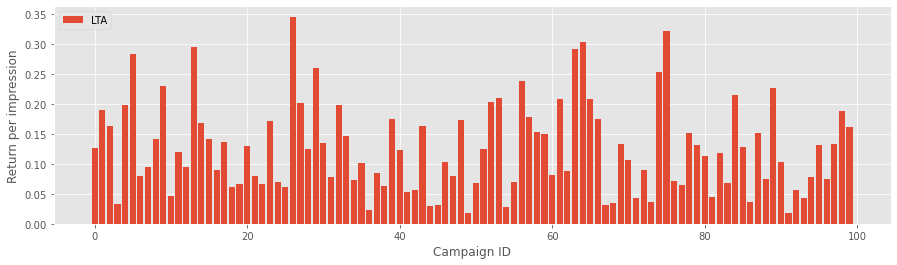

In [ ]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## First Touch Attribution
With a first-touch attribution model, the very first interaction that a customer has with your company receives 100% of the credit for that sale. It’s an easy-to-understand, quick to set up, single-touch model—but that doesn’t necessarily mean that it’s right for every business out there. 

#### Pros of First Touch Attribution:
* Simplicity/ease-of-use
* Quick to set up
* Great for marketers that focus solely on demand generation
* Encourages investment in top-of-funnel activities

#### Cons of First Touch Attribution:
* Overly simplistic
* Overemphasizes top-of-funnel efforts
* Susceptible to technological limitations

In [ ]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df_Attribution)

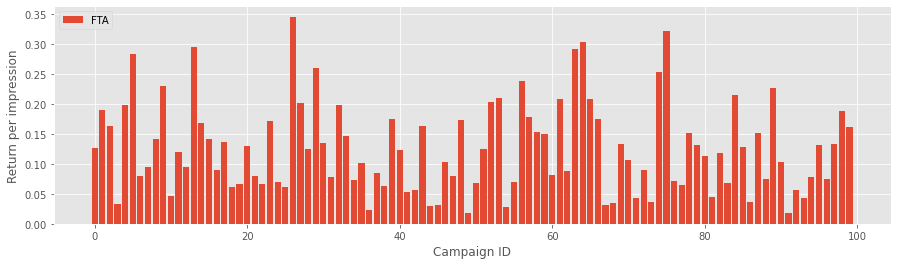

In [ ]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()


# Multi-Touch Attribution

## Linear Attribution

A linear attribution model focuses on multi-touch attribution–meaning it takes into account and attributes credit to multiple touchpoints along the customer journey. In fact, this model actually takes into account every single interaction that a prospect has with your brand prior to purchasing. 

#### Pros of Linear Attribution:

* Takes a multi-touch approach
* Easy to understand
* Doesn’t require in-depth data science capabilities

#### Cons of Linear Attribution:
* Too simplistic
* Treats every touchpoint the same way
* Over time, this could have a significant negative impact on your results

In [ ]:
def Linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    df_converted['linear'] = df_converted.conversion / (df_converted.click_nb).astype(float)
    
    def linear_attr_by_campaign(df_conv):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_conv)):
            campaign_id = np.argmax(df_conv.iloc[idx, 27])
            counters[campaign_id] = counters[campaign_id] + df_conv.iloc[idx, 28]
        
        return counters
    
    campaign_conversions = linear_attr_by_campaign(df_converted)
    
    return campaign_conversions / campaign_impressions
    
linear_attr = Linear_attribution(df_Attribution)

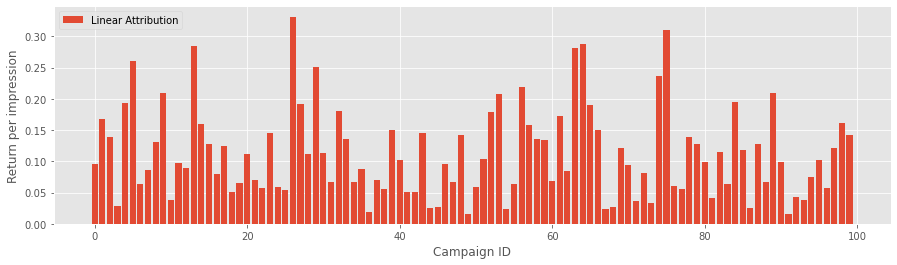

In [ ]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
plt.bar( range(len(linear_attr[campaign_idx])), linear_attr[campaign_idx], label='Linear Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## U-Shaped Attribution
A U-shaped attribution model is pretty easy to understand; the first touchpoint (i.e. interaction that a prospect has with your brand) is given 40% of the overall credit for that sale, while the last touchpoint (the final step before they convert and become a paying customer) is also given 40%. The remaining 20% of the credit is shared equally between all other touchpoints, no matter how many there are. 



In [ ]:
def UShape_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def calc_attribution(click_pos,click_nb):
        default_att = 0.5
        extreme_touch_att = 0.4
        intermed_att = 0.2

        if(click_nb == 2):
            return default_att
        else:
            if(click_pos == click_nb - 1 or click_pos ==0):
                return extreme_touch_att
            else:
                return intermed_att/(click_nb -2)

    
    def UShape_Attr_Value(df_converted):
        df_converted['U_Shape'] = df_converted.apply(lambda val: calc_attribution(val.click_pos,val.click_nb),axis=1)
        return df_converted
        
    def UShape_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx, 27])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 28]
        return counters
    
    

    df_converted = UShape_Attr_Value(df_converted) 
    
    campaign_conversions = UShape_by_campaign(df_converted)   #count conversions by campaign using U-Shape model
        
    return campaign_conversions / campaign_impressions
    
ushape_attr = UShape_attribution(df_Attribution)

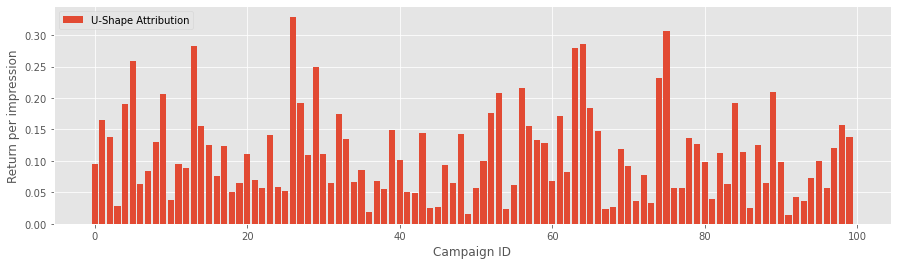

In [ ]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
plt.bar( range(len(ushape_attr[campaign_idx])), ushape_attr[campaign_idx], label='U-Shape Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Time-Deccay Attribution
Time-decay attribution is a multi-touch attribution model that gives some credit to all the channels that led to your customer converting, with that amount of credit being less (decaying) the further back in time the channel was interacted with. 

#### Pros of Time-Decay Attribution:

* Sharing is Caring. Gives some credit to all touchpoints
* Always Be Closing. Touchpoints closest to the conversion are valued the most, which gives preference to marketing channels that tend to do more of the “closing” work
* Consistency is Key. Applying a standardized formula to all of your campaigns will easily highlight fluctuations in the activity of individual channels

#### Cons of Time-Decay Attribution:

* Didn’t See You Back There. Gives less credit to the first touchpoint, which might be the most difficult to execute
* One Size Doesn’t Fit All. Customer journeys are not always a straight line, so the path they took may not be best represented by lowest to highest value interactions
* Hard Numbers. The math involved, while consistent, could be a little complex


In [ ]:
df_Attribution['conversion_day'] = np.floor(df_Attribution.conversion_timestamp / 86400.).astype(int)
def TimeDecay_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        #print('here 1')
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def calc_attribution(conversion_day,click_day):
        rel_pos =  conversion_day - click_day
        attribution = pow(2, -(rel_pos/7))    # using formulae 2^-x/7
        return attribution
    
    def TimeDecay_Attr_Value(df_converted):
        df_converted['TimeDecay'] = df_converted.apply(lambda val: calc_attribution(val.conversion_day,val.day),axis=1)
        return df_converted
        
    def Normalised_TimeDecay(journey_id, Time_Decay):
        attr_sum = df_TDecay_Sum[df_TDecay_Sum.jid == journey_id]['TDsum']
        return Time_Decay / attr_sum       #normalising the attributions by dividing each with the sum of attributions
            
    def TimeDecay_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx, 27])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 29]
        return counters
        
        
    
    df_converted = TimeDecay_Attr_Value(df_converted) 
    
    campaign_conversions = TimeDecay_by_campaign(df_converted)   #count conversions by campaign using U-Shape model
        
    return campaign_conversions / campaign_impressions
    
timedecay_attr = TimeDecay_attribution(df_Attribution)

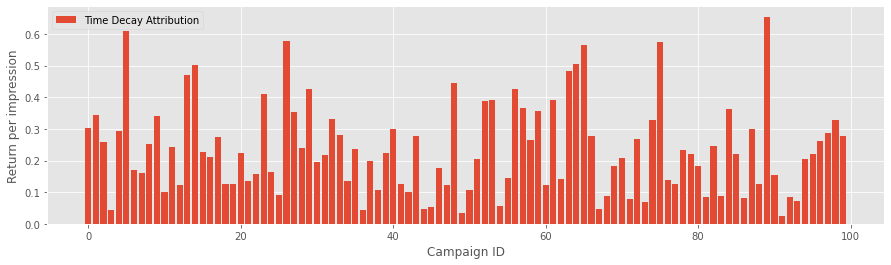

In [ ]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(timedecay_attr[campaign_idx])), timedecay_attr[campaign_idx], label='Time Decay Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Data-Driven Attribution

## Logistic Regression

The first data driven attribution model is based on the work of Shao et al (2011) and Dalessandro et al (2012) and calculates the probability of conversion, in case channels appear in the conversion funnel, vs when they do not, by applying logistic regression. The outcome is a multiplier of the probability of conversion for each channel.

In [ ]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [ ]:
x, y = features_for_logistic_regression(df_Attribution)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [ ]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8557111856381929


In [ ]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Epoch 1/10
634/634 [==============================] - 2s 2ms/step - loss: 0.5916 - accuracy: 0.7013 - val_loss: 0.4728 - val_accuracy: 0.8064
Epoch 2/10
634/634 [==============================] - 1s 1ms/step - loss: 0.4640 - accuracy: 0.8053 - val_loss: 0.4379 - val_accuracy: 0.8208
Epoch 3/10
634/634 [==============================] - 1s 1ms/step - loss: 0.4286 - accuracy: 0.8220 - val_loss: 0.4193 - val_accuracy: 0.8297
Epoch 4/10
634/634 [==============================] - 1s 1ms/step - loss: 0.4151 - accuracy: 0.8324 - val_loss: 0.4078 - val_accuracy: 0.8350
Epoch 5/10
634/634 [==============================] - 1s 1ms/step - loss: 0.4054 - accuracy: 0.8360 - val_loss: 0.4000 - val_accuracy: 0.8402
Epoch 6/10
634/634 [==============================] - 1s 1ms/step - loss: 0.3967 - accuracy: 0.8412 - val_loss: 0.3935 - val_accuracy: 0.8425
Epoch 7/10
634/634 [==============================] - 1s 1ms/step - loss: 0.3842 - accuracy: 0.8442 - val_loss: 0.3882 - val_accuracy: 0.8450
Epoch 

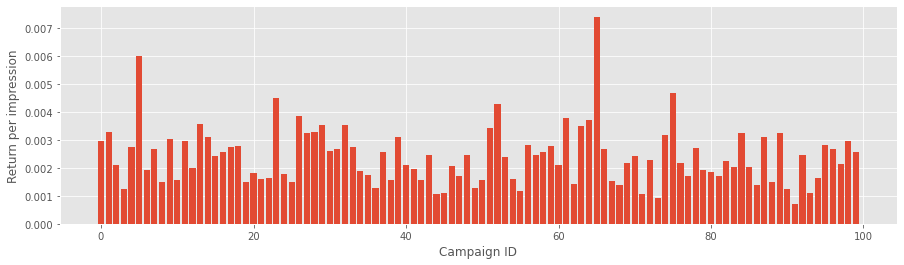

In [ ]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

campaign_idx = range(150, 250)

logistic_attr = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
logistic_attr = softmax([logistic_attr]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(logistic_attr[campaign_idx])), logistic_attr[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

# Comparison of Attribution Models

## Comparison of Last Touch Attribution and First Touch Attribution

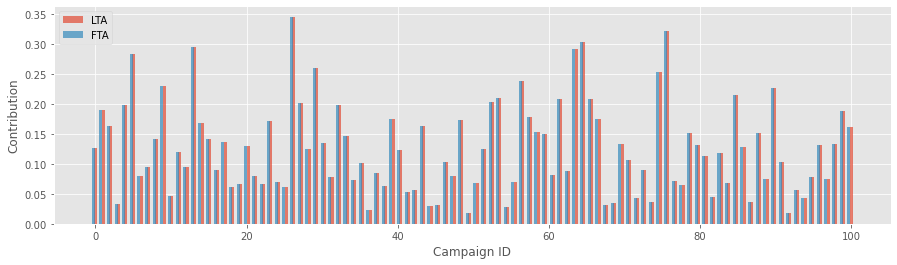

In [ ]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, fta[campaign_idx], width=0.4, alpha=0.7, label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

# Budget Optimization

In [ ]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [ ]:
pitches = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, fta, linear_attr, ushape_attr, timedecay_attr, logistic_attr]

for i, pitch in enumerate(pitches):
    print('Pitch of Budget Allocation - ' + str(pitch))
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df_Attribution, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

Pitch of Budget Allocation - 0.5
0 0 : 916
0 1 : 916
0 2 : 966
